# Automatic Translation

## Imports

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

## Download datasets

Translation dataset used in original paper can be found [here](https://www.tensorflow.org/datasets/catalog/wmt14_translate)

In [2]:
# make dataset directory if doesn't exist
!!mkdir -p datasets

[]

### curl

Use curl to download files from the Internet

`-o` option to set file name when downloaded

`-O` option to keep remote file name

output path can't be specified so manually cd to wanted directory

In [17]:
# Download english language word list
!!cd datasets && curl -o english_words.txt https://gist.githubusercontent.com/deekayen/4148741/raw/98d35708fa344717d8eee15d11987de6c8e26d7d/1-1000.txt

['  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current',
 '                                 Dload  Upload   Total   Spent    Left  Speed',
 '',
 '  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0',
 '100  5839  100  5839    0     0  11916      0 --:--:-- --:--:-- --:--:-- 11916']

In [29]:
# Download french language word list
!!cd datasets && curl -O http://www.lexique.org/databases/Lexique383/Lexique383.zip
!!cd datasets && unzip Lexique383.zip
!!mv datasets/Lexique383.tsv datasets/french_words.txt

[]

In [5]:
# Download english-to-french translation dataset
!!cd datasets && curl -O http://www.manythings.org/anki/fra-eng.zip
!!cd datasets && unzip fra-eng.zip
!!rm datasets/_about.txt

[]

## Preprocessing

Sentences from the source and destination languages are converted to token sequences and padded to the same length. Source sentences are padded on the left and destination sentences on the right. Special tokens representing words not in dicionary (\<UNK\>), start of sequence (\<SOS\>) and end of sequence (\<EOS\>) are added to the destination sentences. There are two generated destination sentences, one for decoder input, and one for decoder ouput. Source language sequences are reversed for better results.

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

### English word list

In [ ]:
# word list for source language
input_words = []

# load source language word list and convert characters to lower
with open('datasets/english_words.txt') as f:
    input_words = f.read().lower().split('\n')
# print(input_words)

# Make source language tokenizer. UNK token is 1
source_tokenizer = Tokenizer(num_words=len(input_words), oov_token=1)
source_tokenizer.fit_on_texts(input_words)

### French word list

In [ ]:
# word list for destination language
target_words = []

# Target language
# load target language word list and convert characters to lower
# with open('datasets/french_words.txt') as f:
#     target_words = f.read().lower().split('\n')
# print(target_words[0])
df = pd.read_csv('datasets/french_words.txt')
print(df.head())

# # Make target language tokenizer. UNK token is 1
# target_tokenizer = Tokenizer(num_words=len(target_words), oov_token=1)
# target_tokenizer.fit_on_texts(target_words)

### English-to-French translation dataset

In [5]:
source_sentences = []
target_sentences_input = []
target_sentences_output = []

lines = []
with open('datasets/fra.txt') as f:
    lines = f.read().split('\n')
# TODO remove limit after testing
for line in lines[:50]:
# for line in lines[:-1]:
    input_sentence, target_sentence, _ = line.split('\t')
    source_sentences.append(input_sentence)
    target_sentences_input.append('<SOS> ' + target_sentence)
    target_sentences_output.append(target_sentence + ' <EOS>')

In [6]:
NUM_SOURCE_WORDS = 50_000
NUM_TARGET_WORDS = 50_000

In [9]:
# Make source language tokenizer
source_tokenizer = Tokenizer(num_words=NUM_SOURCE_WORDS)
source_tokenizer.fit_on_texts(source_sentences)
source_dict = source_tokenizer.word_index

# Make destination language tokenizer
target_tokenizer = Tokenizer(num_words=NUM_TARGET_WORDS)
target_tokenizer.fit_on_texts(target_sentences_input + target_sentences_output)
target_dict = target_tokenizer.word_index

In [10]:
# Tokenize sentences to sequences
source_sequences = source_tokenizer.texts_to_sequences(source_sentences)
target_sequences_input = target_tokenizer.texts_to_sequences(target_sentences_input)
target_sequences_output = target_tokenizer.texts_to_sequences(target_sentences_output)

# Reverse source sequnces
for sequence in source_sequences:
    sequence.reverse()

max_source_len = max([len(sequence) for sequence in source_sequences])
max_target_len = max([len(sequence) for sequence in target_sequences_output])

encoder_input_sequences = pad_sequences(source_sequences, maxlen=max_source_len, padding='pre')
decoder_input_sequences = pad_sequences(target_sequences_input, maxlen=max_target_len, padding='post')
decoder_output_sequences = pad_sequences(target_sequences_output, maxlen=max_target_len, padding='post')

for i in range(49, 50):
    print(str(encoder_input_sequences[i]) + ' ' + str(decoder_input_sequences[i]))

[32  1] [ 1  3 65  0  0  0]


## Build the Model

In [3]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense 

### Embedding layer

Keras documentation: https://keras.io/api/layers/core_layers/embedding/

Turns positive integers (indexes) into dense vectors of fixed size.

e.g. [[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]

This layer can only be used as the first layer in a model.

Arguments:
- **input_dim**: Integer. Size of the vocabulary, i.e. maximum integer index + 1.
- **output_dim**: Integer. Dimension of the dense embedding.

### LSTM layer

Keras documentation: https://keras.io/api/layers/recurrent_layers/lstm/

Long Short-Term Memory layer

Arguments:
- **units**: Positive integer, dimensionality of the output space.
- **kernel_initializer**: Initializer for the kernel weights matrix
- **return_sequences**: Boolean. Whether to return the last output in the output sequence, or the full sequence. Default: False.
- **return_state**: Boolean. Whether to return the last state in addition to the output. Default: False.

return_state returns the lstm output, last hidden state and last cell state and return_sequences returns hidden states for each step as the main output. Both flags can be used at the same time and will return all hidden states, last hidden state and last cell state.

For more information on return_sequences and return_state read [this](https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/)

### Layer initializers

Keras documentation: https://keras.io/api/layers/initializers/

Initializers define the way to set the initial random weights of Keras layers.

Some of the available initializers:
- RandomNormal
- RandomUniform
- Zeros
- Ones

Original paper uses uniform distribution in range \[-0.08, 0.08\]

In [11]:
# Number of tokens is len of source_dict + UNK + 1
n_encoder_tokens = len(source_dict)+2

# Number of tokens is len of target_dict + UNK + 1
n_decoder_tokens = len(target_dict)+2

In [12]:
# # Number of tokens is len of input_words + UNK + 1
# n_encoder_tokens = len(input_words)+2

# # Number of tokens is len of target_words + UNK + 1
# num_decoder_tokens = len(target_words)+2

EMBEDDING_DIM = 1000
LSTM_DIM = 256

### Encoder

In [25]:
encoder_inputs = Input(shape=(max_source_len,))
encoder_embedding = Embedding(n_encoder_tokens, EMBEDDING_DIM)
encoder_lstm = LSTM(
    LSTM_DIM,
    kernel_initializer = tf.keras.initializers.RandomUniform(minval=-0.08, maxval=0.08, seed=None),
    return_state=True
)

encoder = encoder_embedding(encoder_inputs)
encoder, state_h, state_c = encoder_lstm(encoder)

encoder_states = [state_h, state_c]

### Decoder

In [33]:
decoder_inputs = Input(shape=(max_target_len,))
decoder_embedding = Embedding(n_decoder_tokens, EMBEDDING_DIM)
decoder_lstm = LSTM(
    LSTM_DIM, 
    kernel_initializer = tf.keras.initializers.RandomUniform(minval=-0.08, maxval=0.08, seed=None),
    return_sequences=True,
    return_state=True
)
decoder_dense = Dense(n_decoder_tokens, activation='softmax')

decoder = decoder_embedding(decoder_inputs)
decoder, _, _ = decoder_lstm(decoder, initial_state=encoder_states)
decoder = decoder_dense(decoder)

### Model

TODO Use separate models for encoder and decoder

TODO Use beam search

Beam search:
- https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/
- https://towardsdatascience.com/boosting-your-sequence-generation-performance-with-beam-search-language-model-decoding-74ee64de435a
- https://medium.com/machine-learning-bites/deeplearning-series-sequence-to-sequence-architectures-4c4ca89e5654

In [28]:
model = Model([encoder_inputs, decoder_inputs], decoder)

# TODO Make adaptive learning rate using keras.callbacks.LearningRateScheduler
# https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/
# TODO Use SGD optimizer with no momentum, start rate 0.7
# https://keras.io/api/optimizers/sgd/
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Plot the model

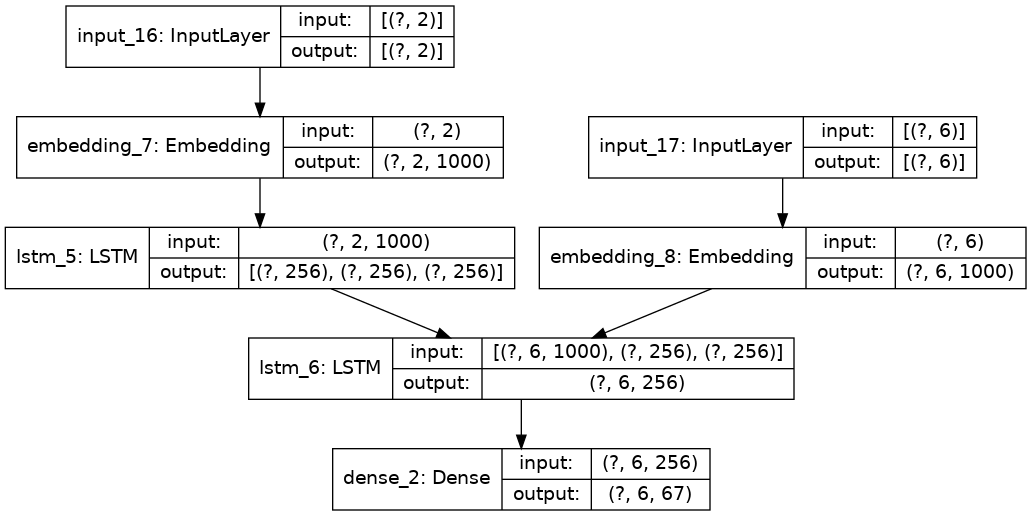

In [29]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# Train the model

In [ ]:
EPOCHS = 10
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2

In [11]:
# Decoder outputs need to be one-hot-encoded for the dense softmax layer to work
from tensorflow.keras.utils import to_categorical
decoder_output = [to_categorical(output) for output in decoder_output_sequences]

In [13]:
print(decoder_output_sequences[0])
print(decoder_output[0])

[8 2 0 0 0 0]
[[0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
history = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_output,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT
)

# Inference

## Build the model

To predict outputs a separate model is needed because the previous decoder output has to be passed in as an input for the next word

In [34]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_h = Input(shape=(LSTM_DIM,))
decoder_state_c = Input(shape=(LSTM_DIM,))
decoder_states = [decoder_state_h, decoder_state_c]

decoder_input_word = Input(shape=(1,))

inference_decoder = decoder_embedding(decoder_input_word)
inference_decoder, state_h, state_c = decoder_lstm(inference_decoder, initial_state=decoder_states)
inference_decoder = decoder_dense(inference_decoder)

inference_states = [state_h, state_c]

decoder_model = Model(
    [decoder_input_word] + decoder_states,
    [inference_decoder] + inference_states
)

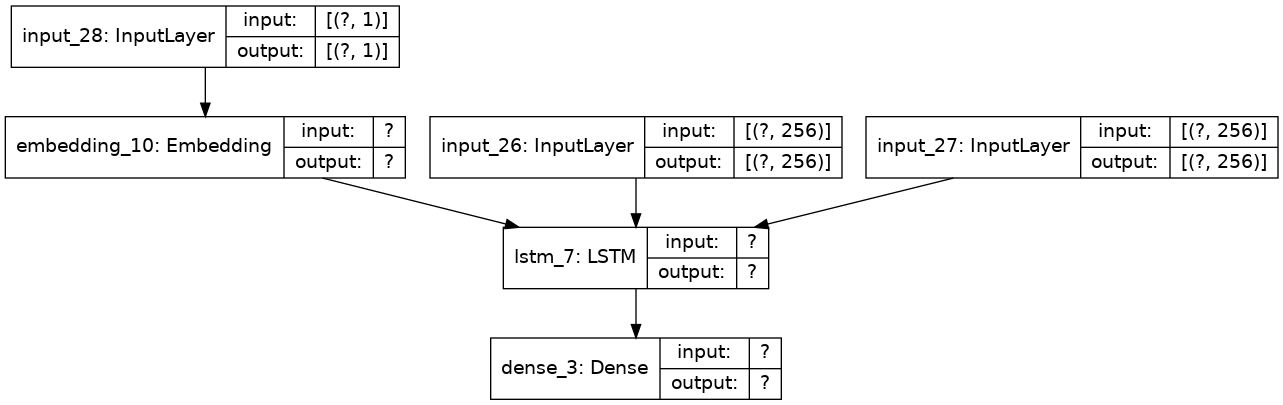

In [35]:
plot_model(decoder_model, to_file='inference_model.png', show_shapes=True, show_layer_names=True)

## Translate

In [36]:
reverse_target_dict = { v:k for k,v in target_dict.items() }

def sequence_to_sentence(sequence):
    words = []
    for i in sequence:
        if i > 0:
            words.append(reverse_target_dict[i])
        else:
            words.append('<UNK>')
    return ' '.join(words)

In [ ]:
def predict(source_sequence):
    # Predict the encoder result directly
    current_state = encoder_model.predict(source_sequence)
    
    # Predict ouput words one at a time until <EOS> token or max_target_len
    EOS_TOKEN = target_dict['<EOS>']
    # decoder_model expects a tensor as input
    decoder_input = np.zeroes((1, 1))
    decoder_input[0, 0] = target_dict['<SOS>']
    target_sequence = []
    for i in range(max_target_length):
        dense_outputs, state_h, state_c = decoder_model.predict([decoder_input] + current_state)
        print(dense_outputs.shape)
        token = np.argmax(dense_outputs[0, 0, :])
        if token == EOS_TOKEN:
            break
        else:
            target_sequence.append(token)
        # Replace decoder inputs to last generated token and states
        decoder_input[0, 0] = token
        current_state = [state_h, state_c]
    return sequence_to_sentence(target_sequence)

# Analysis

## 2D Encoder hidden state PCA

In [2]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
# TODO Predict state for some sentences
sample_sentences = [
   
]

sample_inputs = []

pca = PCA(n_components=2)
pca.fit(sample_inputs)
pca_inputs = pca.transform(sample_inputs)

plt.figure()
plt.scatter(pca_inputs, 'r-')
for i in range(len(sample_sentences))
plt.text(sample_sentences[i], pca[i][0]+10, pca[i][1]-5)
plt.show()

## BLEU score

BLEU (Bilingual Evaluation Understudy) is a score for comparing machine-translated text to one or more reference translations made by a human. Scoring usuall works on indiviual sentences and is then averaged on the entire text. Scores have a value between 0 and 1.

For more info:
- https://en.wikipedia.org/wiki/BLEU
- https://machinelearningmastery.com/calculate-bleu-score-for-text-python/
- https://towardsdatascience.com/bleu-bilingual-evaluation-understudy-2b4eab9bcfd1

In [ ]:
from nltk.translate.bleu_score import sentence_bleu